Based on [Automated Assessment of Visual Aesthetics of Android User
Interfaces with Deep Learning](https://dl.acm.org/doi/pdf/10.1145/3554364.3559113)

In [18]:
from pathlib import Path
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from datetime import datetime

In [2]:
path = Path(os.path.expanduser("~/Downloads/Dataset_estetica/Regressao"))

In [3]:
PATHGLOB = path.glob('./*')
LS = [fil for fil in PATHGLOB]

In [4]:
LS

[PosixPath('/Users/mowoe/Downloads/Dataset_estetica/Regressao/valid'),
 PosixPath('/Users/mowoe/Downloads/Dataset_estetica/Regressao/labels.csv'),
 PosixPath('/Users/mowoe/Downloads/Dataset_estetica/Regressao/.DS_Store'),
 PosixPath('/Users/mowoe/Downloads/Dataset_estetica/Regressao/train')]

In [5]:
df = pd.read_csv(path / 'labels.csv')

In [6]:
df

,image,score,valid
0,0001_app-inventor,0.17,False
1,0002_app-inventor,0.00,False
2,0003_app-inventor,0.00,False
3,0005_app-inventor,0.00,False
4,0006_app-inventor,0.00,False
...,...,...,...
3134,4489_rico,0.50,False
3135,4490_rico,0.67,False
3136,4491_rico,0.17,False
3137,4498_rico,0.67,False


In [7]:
class AppstheticsDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.root_path = Path(root)
        self.dataset = pd.read_csv(path / 'labels.csv')
        if split=="valid":
            self.dataset = self.dataset[self.dataset["valid"] == True]
        else:
            self.dataset = self.dataset[self.dataset["valid"] == False]
        self.split = split
        self.transform = transform
        
    
    def __len__(self):
        return len(self.dataset.values)
        
    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        image_path = row["image"]
        score = row["score"]
        image = Image.open(self.root_path / f"{self.split}/{image_path}.jpg").convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(score).float()

Take a quick look into 16 random sampled images in the dataset:

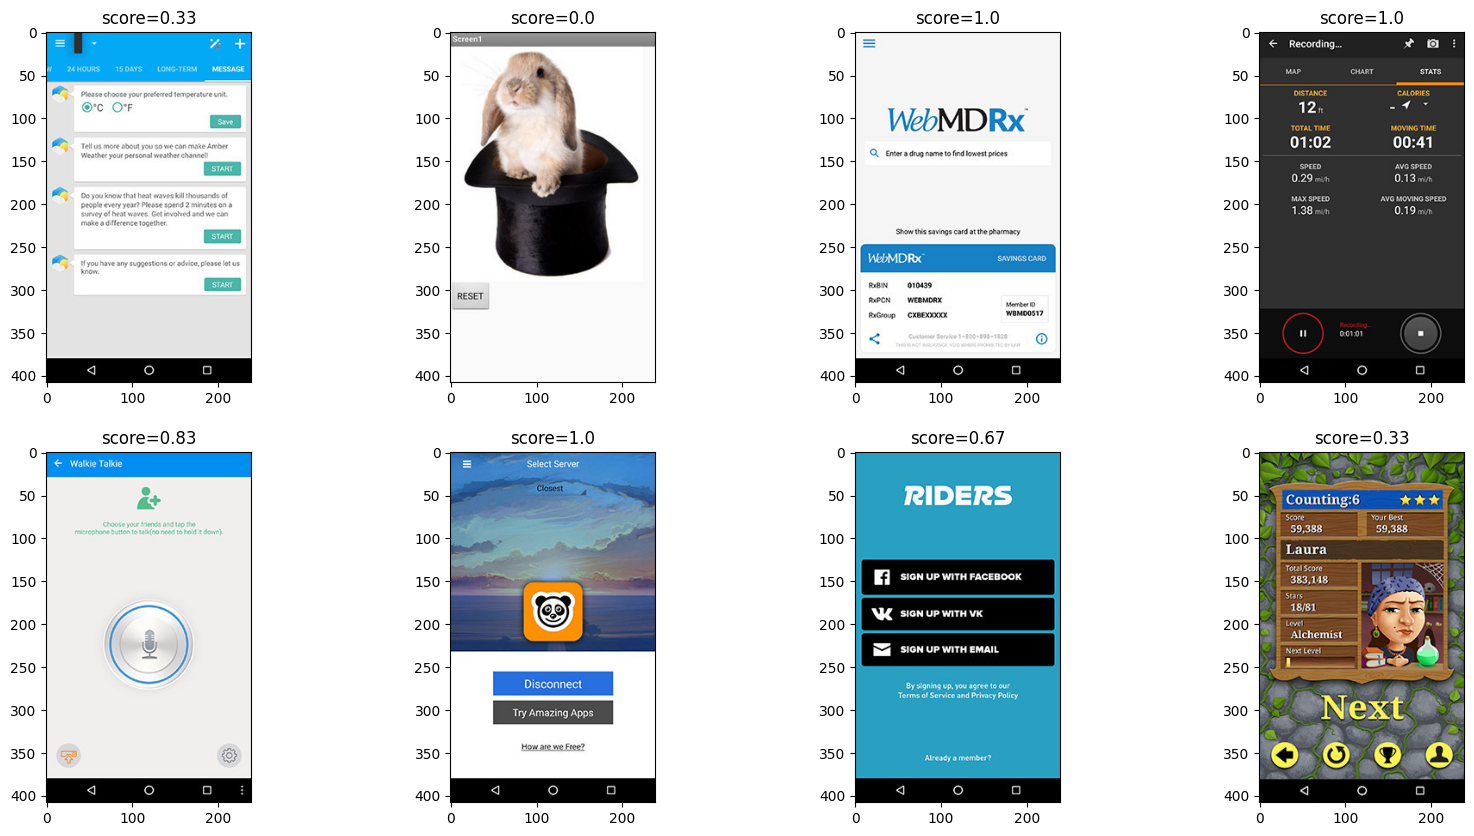

In [8]:
fig = plt.figure(figsize=(20, 10)) 
for n in range(8):
    row = df.sample(n=1)
    image = row["image"].values[0]
    if row["valid"].values[0]:
        im = Image.open(path / f"valid/{image}.jpg")
    else:
        im = Image.open(path / f"train/{image}.jpg")
    fig.add_subplot(2, 4, n+1) 
    plt.imshow(im)
    plt.title(f"score={row['score'].values[0]}")

plt.show()

In [19]:
resnet50 = models.resnet50(pretrained=True)

# Freeze the parameters of the pretrained layers
for param in resnet50.parameters():
    param.requires_grad = False

/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mowoe/Documents/bachelorthesis/venv/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# Modify the final fully connected layer to match the number of classes in your dataset
num_classes = 1  # Change this according to your dataset
resnet50.fc = nn.Linear(resnet50.fc.in_features, num_classes)

# Now, you can fine-tune the model by setting requires_grad=True for the parameters of the final layer
for param in resnet50.fc.parameters():
    param.requires_grad = True

In [21]:
transform_to_t = transforms.Compose([transforms.ToTensor(),transforms.Lambda(lambda x: x.float())])

In [22]:
dataset = AppstheticsDataset(os.path.expanduser("~/Downloads/Dataset_estetica/Regressao"), split="train", transform=transform_to_t)

In [23]:
batch_size = 32
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
epochs = 20

In [24]:
criterion = nn.MSELoss()

In [25]:
optimizer = torch.optim.Adam(resnet50.parameters(), lr=0.003)

In [26]:
epoch_losses = []
for epoch in tqdm(range(epochs)):
    losses = []
    for i, data in tqdm(enumerate(train_loader, 0),total=int(len(dataset)/batch_size)+1,leave=False):
        inputs, labels = data[0], data[1]
        outputs = resnet50(inputs)
        labels = labels.unsqueeze(-1)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach().item())
    print(f"Epoch loss: {sum(losses)/len(losses)}")
    epoch_losses.append(sum(losses)/len(losses))

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.38236511045996147


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.09484999494839318


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.0883788429672205


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.09323188832289056


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.10735987631391876


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.11355790099765681


  0%|          | 0/78 [00:00<?, ?it/s]

Epoch loss: 0.12588301866869384


  0%|          | 0/78 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [27]:
torch.save(resnet50.state_dict(), f"./resnet_50_{epochs}_epochs_{datetime.now().isoformat(timespec='minutes')}")

In [59]:
torch.save(resnet50, f"./resnet_50_{epochs}_epochs_{datetime.now().isoformat(timespec='minutes')}")

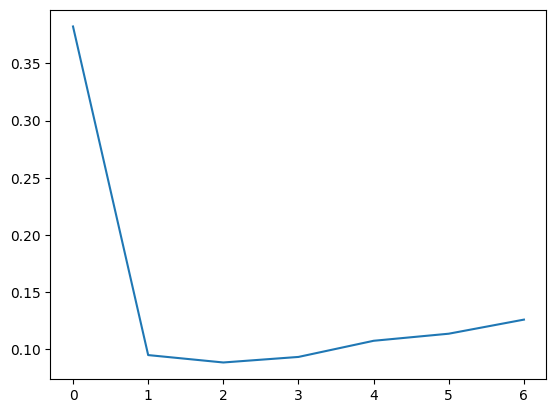

In [28]:
plt.plot(epoch_losses)
plt.show()

In [29]:
test_dataset = AppstheticsDataset(os.path.expanduser("~/Downloads/Dataset_estetica/Regressao"), split="train", transform=transform_to_t)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [51]:
len(test_dataset)

2509

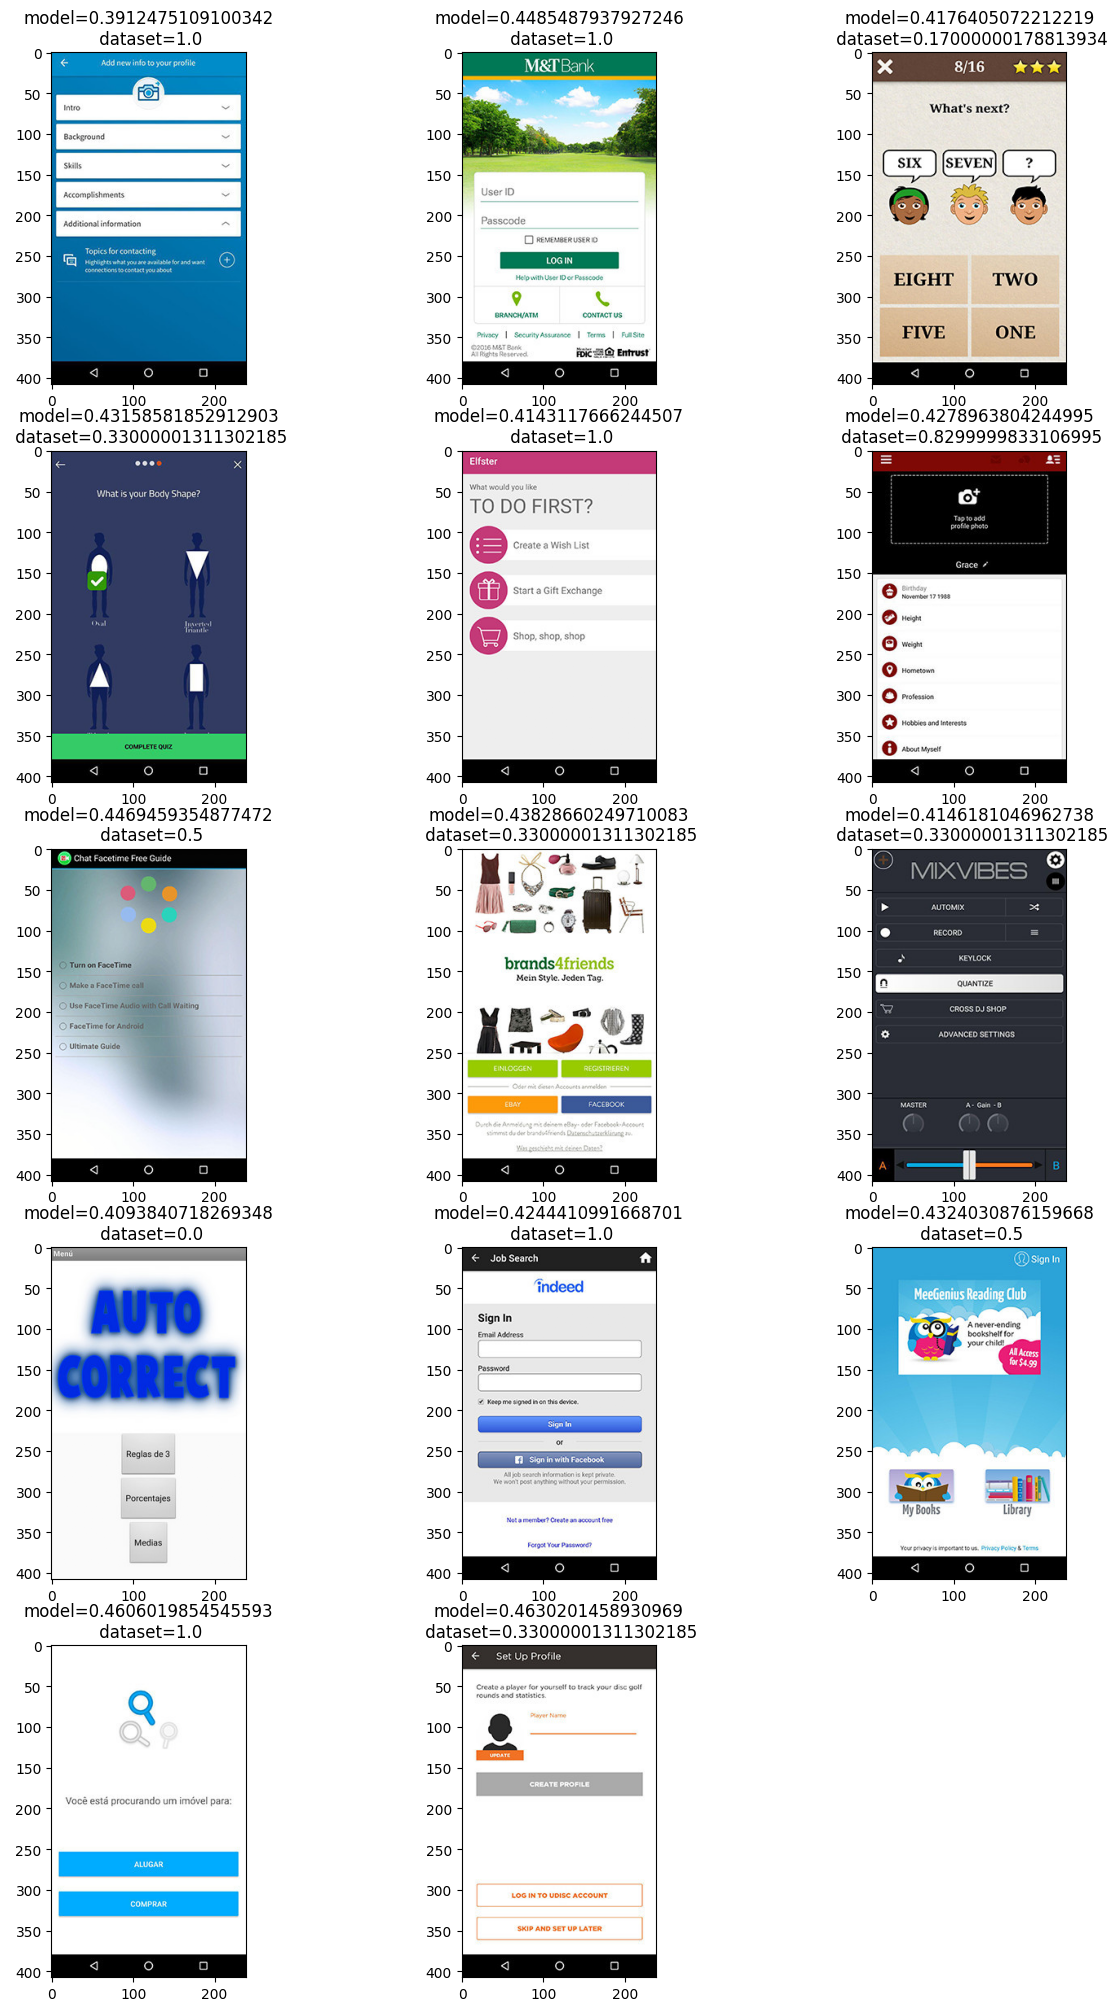

In [58]:
fig = plt.figure(figsize=(15, 25)) 

#for x in range(8):
for i, data in enumerate(test_loader, 0):
    inputs, labels = data[0], data[1]
    outputs = resnet50(inputs)
    fig.add_subplot(5, 3, i+1)
    plt.imshow(inputs[0].permute(1, 2, 0))
    plt.title(f"model={outputs.item()}\n dataset={labels.item()}")
    
    if i > 12:
        break

plt.show()